<a href="https://colab.research.google.com/github/XaviJunior/SBB/blob/master/SBB_ShapEli5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from cleaning import df
from custom_functions import custom_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

Using TensorFlow backend.


In order to get reproducible as well as comparable results, we arbitrarily chose a **random seed** to be used during the train/test split and as a parameter for some models.

In [0]:
RSEED = 42

All the main **test results** were recorded in `documents/ml_results.xlsx`. Parts of it are shown in this notebook, but please refer to the original file for a complete overview.

## 3. Machine learning models<a name="ml"></a>

Before going into the details of each model, here is an overview of how they performed against the base rate (best scores). As you can see, compared to random guessing, machine learning enables us to increase accuracy by about **4** to **6%**.

###Install and import for Shap, Eli5 and model evaluation

In [0]:
!pip install eli5
!pip install shap

In [0]:
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


###XGBoost
for Analysis with Eli5 and Shap

In [0]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="label",
                                                pca=False, poly=False,
                                                features=["goal", "time", "category", "main_category", "country"])
X_train.columns = ['goal', 'time', 'category', 'main_category', 'country']
X_test.columns = ['goal', 'time', 'category', 'main_category', 'country']
X_train.head()

,goal,time,category,main_category,country
235186,-0.029525,0.412803,8,13,1
109545,-0.039363,-0.078690,69,6,21
224633,0.092953,-0.063301,136,8,21
124354,-0.036852,-0.227073,52,5,21
351930,-0.039068,0.414482,106,8,21


In [0]:
%%time

import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

CPU times: user 1min 42s, sys: 100 ms, total: 1min 42s
Wall time: 1min 42s


In [0]:
predictions = xgc.predict(X_test)
predictions[10:]

array([0, 0, 1, ..., 1, 0, 0])

In [0]:
class_labels = list(set(df["state"]))
meu.display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.7047
Precision: 0.6942
Recall: 0.7047
F1 Score: 0.6912

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.73      0.85      0.79     47218
           1       0.63      0.45      0.52     26826

    accuracy                           0.70     74044
   macro avg       0.68      0.65      0.66     74044
weighted avg       0.69      0.70      0.69     74044


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   0      1
Actual: 0      40109   7109
        1      14756  12070


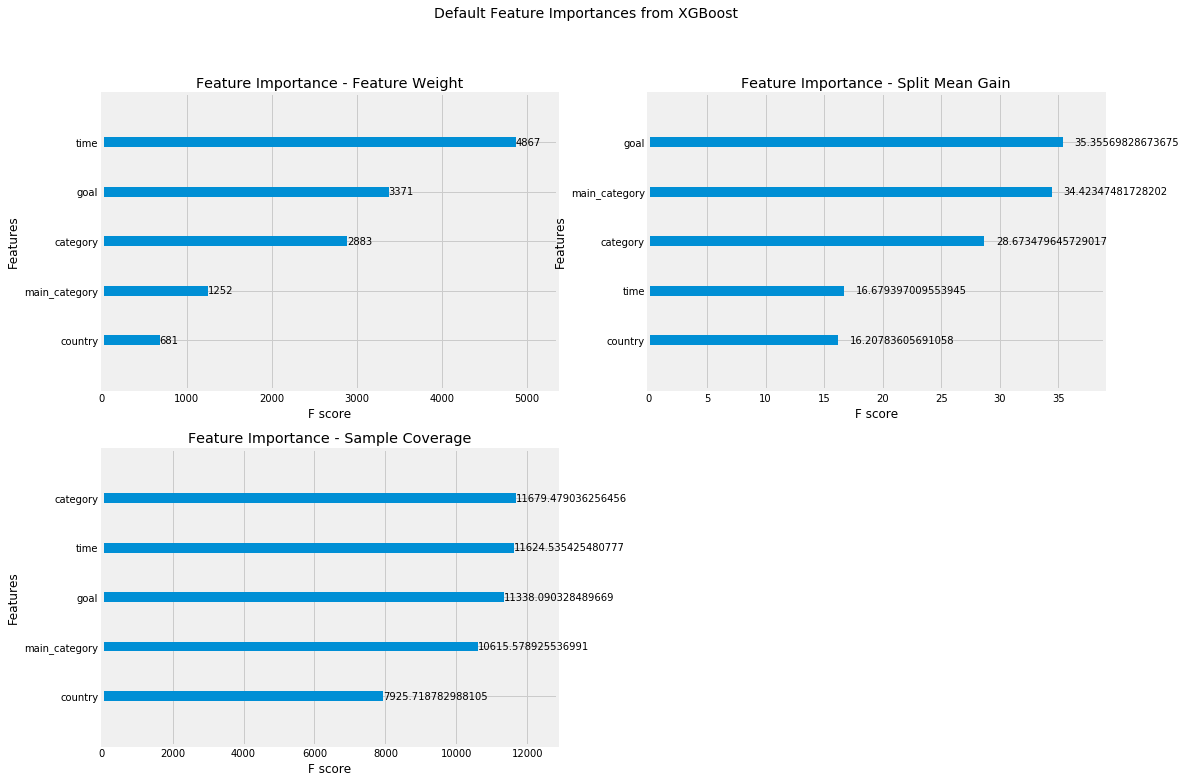

In [0]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

In [0]:
eli5.show_weights(xgc.get_booster())

Weight,Feature
0.2692,goal
0.2621,main_category
0.2183,category
0.1270,time
0.1234,country


In [0]:
doc_num = 0
print("The classifier predict :", predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=['goal', 'time', 'category', 'main_category', 'country'], show_feature_values=True)

The classifier predict : 0


In [0]:
doc_num = 3#len(predictions)-3
print("The classifier predict :", predictions[doc_num]) #list of prediction from the xgboost classifier
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(X_test.columns), 
                     show_feature_values=True)

The classifier predict : 0


###Skater

pas hyper relevant dans notre cas....

In [0]:
!pip install skater

In [0]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(training_data=X_test, training_labels=y_test, 
                             feature_names=list(X_test.columns))
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, 
                         target_names=[0, 1])

2020-03-07 19:10:17,770 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[5/5] features ████████████████████ Time elapsed: 22 seconds

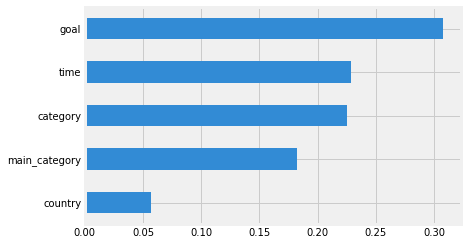

In [0]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, 
                                                               n_samples=23000)

2020-03-07 19:13:00,252 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[44/44] grid cells ████████████████████ Time elapsed: 25 seconds

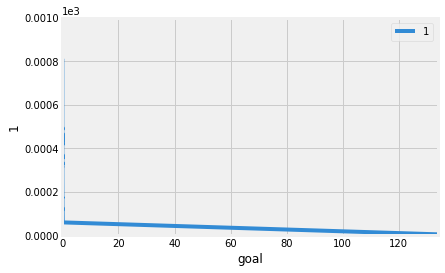

In [0]:
r = interpreter.partial_dependence.plot_partial_dependence(['goal'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

2020-03-07 19:17:06,108 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[50/50] grid cells ████████████████████ Time elapsed: 29 seconds

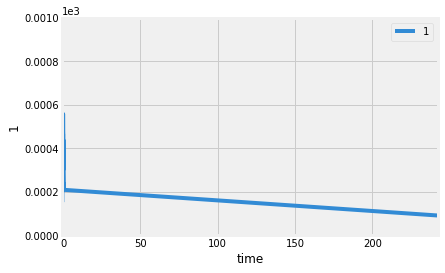

In [0]:
r = interpreter.partial_dependence.plot_partial_dependence(['time'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

###Shap

In [0]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head()

Expected Value: -0.5805271


,0,1,2,3,4
0,-0.787521,0.195050,0.160321,0.200852,0.072440
1,0.749523,0.152717,-0.375799,-0.262388,0.051987
2,0.198401,0.477032,-0.345366,-0.284256,0.039862
3,-0.081098,-0.318902,-0.157761,-0.340341,0.042092
4,-0.145915,-0.239909,0.094403,0.337181,0.070578


In [0]:
X_test.head(1)

,goal,time,category,main_category,country
0,0.004349,-0.077704,67,13,21


In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


std = StandardScaler()
X1 = pd.DataFrame()
X1 = pd.concat((X1, df["usd_goal_real"]), axis=1)
time_std = pd.DataFrame(std.fit_transform(pd.to_numeric(df["elapsed_time"]).to_numpy().reshape(-1, 1)))
X1 = pd.concat((X1, time_std), axis=1)
X1.columns = ["goal", "time"]
X1 = pd.concat((X1, df["category"]), axis=1)
X1 = pd.concat((X1, df["main_category"]), axis=1)
X1 = pd.concat((X1, df["country"]), axis=1)

X1.head(1)


,goal,time,category,main_category,country
0,1533.95,0.406008,Poetry,Publishing,GB


In [0]:
from sklearn.model_selection import train_test_split
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(X1, df["state"], test_size=0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(259153, 5) (111066, 5)


,goal,time,category,main_category,country
164476,14888.71,0.171895,Flight,Technology,SG
307060,1500.00,-0.075122,Comics,Comics,US
77986,10000.00,-0.046270,Community Gardens,Food,US


In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test_disp.iloc[0,:])

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[2,:], X_test_disp.iloc[2,:])

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], X_test_disp.iloc[:1000,:])

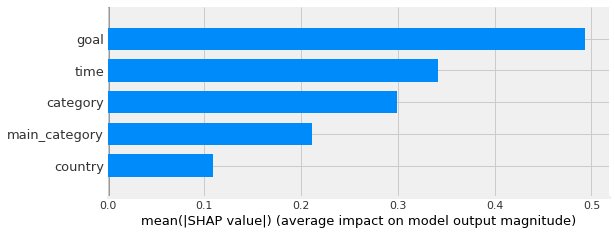

In [0]:
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

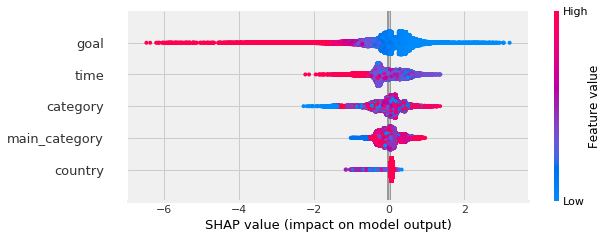

In [0]:
shap.summary_plot(shap_values, X_test)

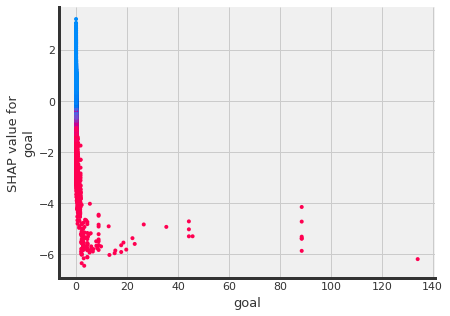

In [0]:
shap.dependence_plot(ind='goal', interaction_index='goal',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

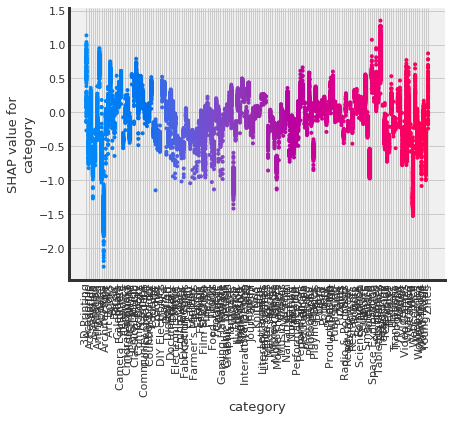

In [0]:
shap.dependence_plot(ind='category', interaction_index='category',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

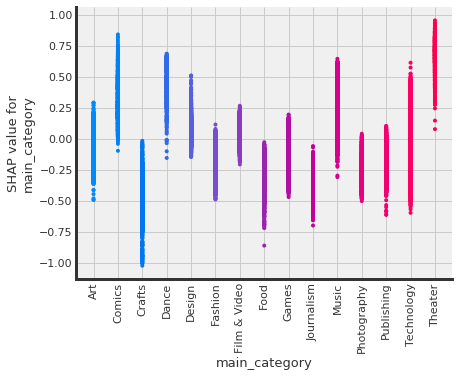

In [0]:
shap.dependence_plot(ind='main_category', interaction_index='main_category',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

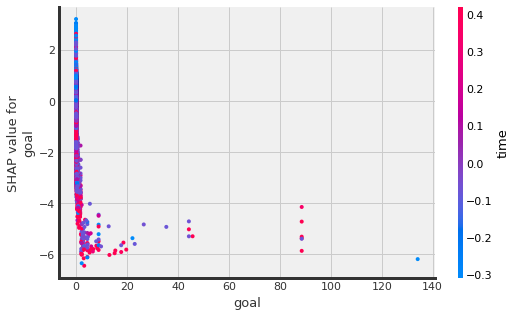

In [0]:
shap.dependence_plot(ind='goal', interaction_index='time', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

### A. Logistic regression<a name="logr"></a>

In [0]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="label",
                                                pca=False, poly=False,
                                                features=["goal", "time", "category", "main_category", "country"])
X_test=pd.get_dummies(X_test)
X_train=pd.get_dummies(X_train)
features=list(X_test.columns.values)
features[0]='Goal'
features[1]='Time'

In [0]:
%%time

LR = LogisticRegressionCV(solver="lbfgs", cv=5, max_iter=1000, random_state=RSEED)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

CPU times: user 1min 9s, sys: 42.9 s, total: 1min 52s
Wall time: 56.6 s


###Predictions of the Logistic Regression

In [0]:
predictions = LR.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 0, 0])

### Model evaluation

In [0]:
class_labels = list(set(df["state"]))
meu.display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.6427
Precision: 0.6157
Recall: 0.6427
F1 Score: 0.5359

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.65      0.97      0.78     47218
           1       0.56      0.06      0.11     26826

    accuracy                           0.64     74044
   macro avg       0.60      0.52      0.44     74044
weighted avg       0.62      0.64      0.54     74044


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0      45908  1310
        1      25144  1682


### D. Random forest<a name="rf"></a>

After having experimented with decision trees, the next logical step was to try the related random forest ensemble (mostly because we were curious to see by how much accuracy would actually increase compared to decision trees).

Random forests being quite **intensive** in terms of computation, we did not run as many tests as with previous models (especially not the ones with one-hot encoding!). To wit, we only picked the set of features that worked best for decision trees.

In [0]:
%%time

RF = RandomForestClassifier(criterion="entropy", n_estimators=100, max_depth=15, random_state=RSEED)
RF.fit(X_train, y_train)
RF.score(X_test, y_test)

CPU times: user 1min 6s, sys: 77.1 ms, total: 1min 6s
Wall time: 1min 6s


In [0]:
predictions = RF.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
class_labels = list(set(df["state"]))
meu.display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.6988
Precision: 0.6873
Recall: 0.6988
F1 Score: 0.6804

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.72      0.86      0.79     47218
           1       0.63      0.41      0.50     26826

    accuracy                           0.70     74044
   macro avg       0.67      0.64      0.64     74044
weighted avg       0.69      0.70      0.68     74044


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   0      1
Actual: 0      40765   6453
        1      15850  10976


In [0]:
eli5.show_weights(RF)

Weight,Feature
0.3467 ± 0.0281,x0
0.3040 ± 0.0341,x1
0.1857 ± 0.0276,x2
0.1165 ± 0.0249,x3
0.0471 ± 0.0060,x4


### E. Neural network<a name="nn"></a>

As our final classification model, we were curious to experiment briefly with neural networks. However, the analysis conducted with previous models already told us much about the relevance of each feature; following the TA's advice, we did not spend too much time exploring neural networks and restricted ourselves to the set of parameters and the layer configuration seen during the course.

In [0]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="onehot",
                                                pca=False, poly=False,
                                                features=["goal", "time", 
                                                          "category", "main_category", "country"])

Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)

NN = Sequential()
NN.add(Dense(512, input_shape=(X_train.shape[1],)))
NN.add(Activation("relu"))
NN.add(Dropout(0.2))
NN.add(Dense(2))
NN.add(Activation("softmax"))

optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
NN.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

NN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               101888    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_5 (Activation)    (None, 2)                 0         
Total params: 102,914
Trainable params: 102,914
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_hist = NN.fit(X_train, Y_train, batch_size=64, epochs=30, verbose=0, validation_split=0.2)

#### Results

We were disappointed to observe that, out of all the classifiers we tried, the neural network gave us the **worst** performance. That being said, the difference is so small that we might as well say it is insignificant. Moreover, adding more layers and adjusting other parameters would probably have yielded better results.

In terms of features, the previous observations still hold here: adding more features increases accuracy, but none more so than the specific `category`.

Finally, hearkening back to logistic regression, **standard scaling** and **one-hot encoding** seem to work the best on neural networks.

In [0]:
results["NeuralNetwork"].loc[:,:].fillna("-")

,goal,time,category,main_category,country,accuracy
0,STD,STD,OH,OH,OH,0.6811
1,STD,-,OH,OH,-,0.6718
2,MM,MM,OH,OH,OH,0.6706
3,-,-,OH,OH,OH,0.6703
4,-,-,OH,-,-,0.6666
5,MM,MM,LE,LE,LE,0.6448
6,-,-,LE,-,-,0.6405


### F. (Bonus!) Linear regression<a name="linr"></a>

As a side project, we also experimented with **linear regression** to see if the data allowed us to accurately predict the amount of money pledged to a certain project (`usd_pledged_real`).

In [0]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="usd_pledged_real", rseed=RSEED,
                                                scaling="std", encoding="onehot", 
                                                pca=False, poly=False,
                                                features=["time", "goal", 
                                                          "category", "main_category", "country"])

"""
ridge = RidgeCV()
ridge.fit(X_train, y_train)
print("R^2:", ridge.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, ridge.predict(X_test)))
"""

LinR = LinearRegression(fit_intercept=True)
LinR.fit(X_train, y_train)
print("R^2:", LinR.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, LinR.predict(X_test)))

R^2: 0.013445023293411018
MSE: 7757534563.273292


#### Results

In [0]:
results["LinearRegression"].loc[[0,1,2,3,4,15],:].fillna("-")

,goal,time,category,main_category,country,poly,r^2
0,STD,STD,OH,OH,OH,-,0.013445
1,-,-,OH,-,-,-,0.013090
2,-,-,-,OH,-,-,0.007043
3,STD,STD,-,OH,-,2,0.005222
4,STD,STD,LE,LE,LE,2,0.001451
15,STD,STD,-,OH,-,3,-131.084931


We quickly realized that linear regression gave very **low** (sometimes even negative...) **scores** and **high error**, no matter which features were used.

Using **higher polynomial functions** or **ridge regression** instead did not help either, not to mention it was not possible to use the one-hot encoded `category` (which, so far, has usually allowed us to reach higher scores); the computation becomes just too long and results in memory errors.

Nevertheless, a couple of observations can be scavenged from the data that we gathered:

* Taking categorical variables into account leads to higher scores.
* There is no difference between min-max and standard scaling.
* Label encoding does not make much sense in the context of linear regression. It is preferable to use one-hot encoding.
* Given the very low scores, adjusting the `fit_intercept` parameter does not affect results significantly.
* Polynomial functions do not fit the data well.

We therefore conclude that the features available in the dataset are not enough to make linear regression work. It is unfortunately not possible to use this model to make any meaningful predictions. 

## 4. Conclusion<a name="conclusion"></a>

We started out with around **380,000 records of Kickstarter project metadata**, hoping to use it to build an effective model for predicting the success or failure of a project.

After having experimented with various machine learning models, we come to the conclusion that the data contained in the dataset is **not sufficient to provide a reliable model**. Our best (and rather inefficient) model, the **random forest**, performed only 6.4% better than the baseline approach. No significant difference was found between the various classifiers (from 68.11% for the worst model, to 70.02% for the best). The most efficient one was the **decision tree**, taking only a couple of seconds to run and boasting an accuracy of almost 69%. The **k-NN** also deserves an honorable mention; with the help of PCA, it is able to push accuracy above 69% in a reasonably short time.

More knowledgeable data scientists will be able to **better fine-tune** the models we used, but it is our belief that they might only be able to squeeze 1 or 2 extra percents out of it at best.

Unfortunately, our dataset did not contain the **project descriptions**. Had that been the case, it would have been interesting to conduct **text analysis** on the whole corpus in order to predict the success/failure. Indeed, it is our assumption that, in addition to the video, the project description is a very important aspect of a Kickstarter project in terms of marketing, and that it can have a much greater impact on the amount of money collected than, say, the category or country.
 
Our dataset contains informative, but **basic** metadata that do not have strong interdependencies with the final state of projects. Despite the large number of records, it is **difficult to identify a well-defined trend**.

Still, based on the data we were working with, we can conclude that the **specific category** (`category`) coupled with the **goal** set by the project creator (`usd_goal_real`) are the most relevant features for predicting success or failure.

As mentioned above, the descriptions of the different projects would have given us more leads for analysis and thus would have allowed us to formulate some hypotheses related to the success of a project, such as:
 
* Marketing analysis and the financial means used to promote the project (before and after the launch of the Kickstarter campaign)
* Available resources
* Supply and demand analysis
* The level of innovation of the project
* etc.
 
This would undoubtedly have made our results more relevant.